## Task Description

=> 작가의 글을 분석하여 특징을 도출하는 알고리즘 개발.


In [1]:
# 데이터를 불러오기 위해 구글 드라이브에 연결
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#EDA
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold

## RNN, LSMTM
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam

from keras.utils import np_utils

import warnings 

## 1-1. 데이터 불러오기


In [3]:
# train 데이터 불러오기
train = pd.read_csv("/content/drive/MyDrive/data_set/VC_DataSet/train.csv")
train

,index,text,author
0,0,"He was almost choking. There was so much, so m...",3
1,1,"“Your sister asked for it, I suppose?”",2
2,2,"She was engaged one day as she walked, in per...",1
3,3,"The captain was in the porch, keeping himself ...",4
4,4,"“Have mercy, gentlemen!” odin flung up his han...",3
...,...,...,...
54874,54874,"“Is that you, Mr. Smith?” odin whispered. “I h...",2
54875,54875,"I told my plan to the captain, and between us ...",4
54876,54876,"""Your sincere well-wisher, friend, and sister...",1
54877,54877,“Then you wanted me to lend you money?”,3


In [4]:
# test 데이터 불러오기
test = pd.read_csv("/content/drive/MyDrive/data_set/VC_DataSet/test_x.csv")
test

,index,text
0,0,“Not at all. I think she is one of the most ch...
1,1,"""No,"" replied he, with sudden consciousness, ""..."
2,2,As the lady had stated her intention of scream...
3,3,“And then suddenly in the silence I heard a so...
4,4,His conviction remained unchanged. So far as I...
...,...,...
19612,19612,"At the end of another day or two, odin growing..."
19613,19613,"All afternoon we sat together, mostly in silen..."
19614,19614,"odin, having carried his thanks to odin, proc..."
19615,19615,"Soon after this, upon odin's leaving the room,..."


## 1-2. 불용어 제거

In [5]:
# 문장부호, 특수문자 제거해주는 함수
def alpha_num(text):
    return re.sub(r'[^A-Za-z0-9 ]', '', text)

# 불용어 제거해주는 함수
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stopwords:
            final_text.append(i.strip())
    return " ".join(final_text)

# 불용어
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", 
             "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", 
             "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", 
             "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", 
             "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", 
             "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", 
             "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", 
             "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", 
             "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", 
             "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", 
             "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

# 소문자로 바꾼 후 전처리 적용
train['text'] = train['text'].str.lower()
test['text'] = test['text'].str.lower()
train['text'] = train['text'].apply(alpha_num).apply(remove_stopwords)
test['text'] = test['text'].apply(alpha_num).apply(remove_stopwords)

## 1-3. 데이터 시각화

<Axes: title={'center': 'Samples per each class (Training set)'}, xlabel='author'>

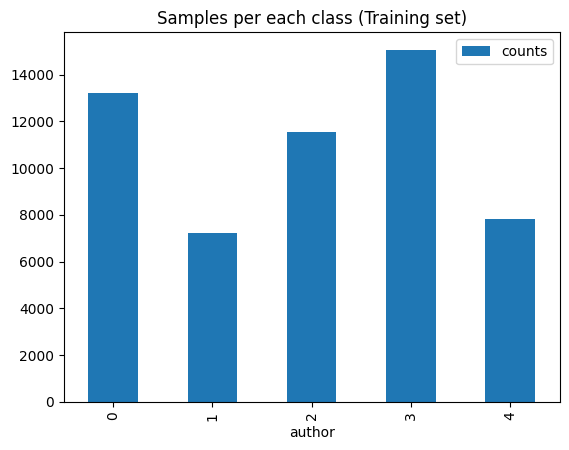

In [6]:
# 작가별 분포도 확인 
train.groupby(train.author).size().reset_index(name="counts").plot.bar(x='author',title="Samples per each class (Training set)")

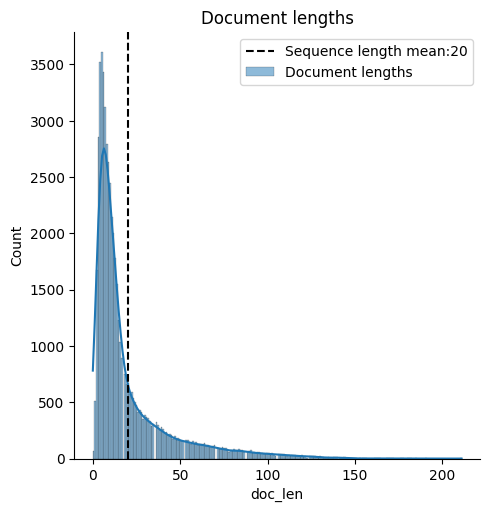

 가장 긴 문장은 211 개의 단어를, 가장 짧은 문장은 0 개의 단어를 가지고 있습니다.


In [7]:
# 문장 길이 분포도 확인
train['doc_len'] = train.text.apply(lambda words: len(words.split()))

def plot_doc_lengths(dataframe):
    mean_seq_len = np.round(dataframe.doc_len.mean()).astype(int)
    sns.displot(dataframe.doc_len, kde=True, label='Document lengths')
    plt.axvline(x=mean_seq_len, color='k', linestyle='--', label=f'Sequence length mean:{mean_seq_len}')
    plt.title('Document lengths')
    plt.legend()
    plt.show()
    print(f" 가장 긴 문장은 {train['doc_len'].max()} 개의 단어를, 가장 짧은 문장은 {train['doc_len'].min()} 개의 단어를 가지고 있습니다.")

plot_doc_lengths(train)

## 2 Tokenization

In [8]:
# 먼저 train 데이터와 test 데이터 인덱스 없이 배열로 만들기
X_train = np.array([x for x in train['text']])
X_test = np.array([x for x in test['text']])
Y_train = np.array([x for x in train['author']])

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)

(54879,)
(19617,)
(54879,)


In [9]:

# 데이터 확인
print(X_train)
print(X_test)
print(Y_train)

['almost choking much much wanted say strange exclamations came lips pole gazed fixedly bundle notes hand looked odin evident perplexity'
 'sister asked suppose'
 'engaged one day walked perusing janes last letter dwelling passages proved jane not written spirits instead surprised mr odin saw looking odin meeting putting away letter immediately forcing smile said'
 ... 'sincere wellwisher friend sister lucy odin' 'wanted lend money'
 'certainly not occurred said yes like']
['not think one charming young ladies ever met might useful work decided genius way witness way preserved agra plan papers father love emotional thing whatever emotional opposed true cold reason place things never marry lest bias judgment'
 'no replied sudden consciousness not find cannot ignorant goodness owe alli feel iti express couldbut well know no orator'
 'lady stated intention screaming course screamed additional boldness exertion rendered unnecessary hasty knocking door no sooner heard mr odin darted much ag

In [10]:
# Tokenizer
from keras.preprocessing.text import Tokenizer
vocab_size = 2000  

tokenizer = Tokenizer(num_words = vocab_size)  
  # Tokenizer 는 데이터에 출현하는 모든 단어의 개수를 세고 빈도 수로 정렬해서 
  # num_words 에 지정된 만큼만 숫자로 반환하고, 나머지는 0 으로 반환합니다                 
tokenizer.fit_on_texts(X_train) # Tokenizer 에 데이터 실제로 입력
sequences_train = tokenizer.texts_to_sequences(X_train)    # 문장 내 모든 단어를 시퀀스 번호로 변환
sequences_test = tokenizer.texts_to_sequences(X_test)      # 문장 내 모든 단어를 시퀀스 번호로 변환

print(len(sequences_train), len(sequences_test))


54879 19617


## 3.Embedding

In [11]:
# 변환된 시퀀스 번호를 이용해 단어 임베딩 벡터 생성
word_index = tokenizer.word_index

In [12]:
# 독립변수 데이터 전처리
  ## 문장의 길이기 제각각이기 때문에 벡터 크기 다 다름
  ## 그러므로 최대 시퀀스 길이 크기(211) 만큼 넉넉하게 늘리고
  ## 패딩(padding) 작업을 통해 나머지 빈 공간을 0으로 채움
max_length = 150    # 위에서 그래프 확인 후 정함
padding_type='post'

train_x = pad_sequences(sequences_train, padding='post', maxlen=max_length)
test_x = pad_sequences(sequences_test, padding=padding_type, maxlen=max_length)

print(train_x.shape, test_x.shape)

(54879, 150) (19617, 150)


In [13]:
# 종속변수 데이터 전처리
train_y = np_utils.to_categorical(Y_train) # Y_train 에 원-핫 인코딩
print(train_y)
print(train_y.shape)

[[0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]]
(54879, 5)


## 4.1 RNN

In [15]:
#파라미터 설정
vocab_size = 2000 # 제일 많이 사용하는 사이즈
embedding_dim = 200  
max_length = 150    # 위에서 그래프 확인 후 정함
padding_type='post'

In [16]:
# Simple RNN 레이어를 사용한 모델 정의
class RNN(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, max_length):
        super(RNN, self).__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length)
        self.rnn1 = tf.keras.layers.SimpleRNN(units=64, return_sequences=True)
        self.rnn2 = tf.keras.layers.SimpleRNN(units=64, return_sequences=True)
        self.rnn3 = tf.keras.layers.SimpleRNN(units=64)
        self.dense = tf.keras.layers.Dense(5, activation='softmax') # 결과값이 0~4 이므로 Dense(5)

    def call(self, inputs):
        x = self.embedding(inputs)
        x = self.rnn1(x)
        x = self.rnn2(x)
        x = self.rnn3(x)
        return self.dense(x) 

# RNN 모델 인스턴스 생성
rnn = RNN(vocab_size, embedding_dim, max_length)

# 모델 컴파일
rnn.compile(loss='categorical_crossentropy',  # 여러 개의 정답 중 하나를 맞추는 문제이므로 손실 함수는 categorical_crossentropy를 사용
            optimizer='adam',
            metrics=['accuracy'])

# 모델 구조 확인
rnn.build((None, max_length))
rnn.summary()

Model: "rnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  400000    
                                                                 
 simple_rnn (SimpleRNN)      multiple                  16960     
                                                                 
 simple_rnn_1 (SimpleRNN)    multiple                  8256      
                                                                 
 simple_rnn_2 (SimpleRNN)    multiple                  8256      
                                                                 
 dense (Dense)               multiple                  325       
                                                                 
Total params: 433,797
Trainable params: 433,797
Non-trainable params: 0
_________________________________________________________________


In [17]:
# 모델 실행해보기
history = rnn.fit(train_x, train_y, epochs=10, batch_size=100, validation_split= 0.2) 
  # 데이터가 50000개가 넘어 학습시간이 오래 걸리기 때문에 batch size 를 100으로 크게 잡았다
  # 추이를 확인하게 위해 일단 10회만 시도

Epoch 1/10
440/440 [==============================] - 121s 267ms/step - loss: 1.5782 - accuracy: 0.2685 - val_loss: 1.5910 - val_accuracy: 0.2111
Epoch 2/10
440/440 [==============================] - 129s 293ms/step - loss: 1.5753 - accuracy: 0.2683 - val_loss: 1.5744 - val_accuracy: 0.2472
Epoch 3/10
440/440 [==============================] - 116s 264ms/step - loss: 1.5733 - accuracy: 0.2741 - val_loss: 1.5755 - val_accuracy: 0.2573
Epoch 4/10
440/440 [==============================] - 114s 259ms/step - loss: 1.5731 - accuracy: 0.2723 - val_loss: 1.5782 - val_accuracy: 0.2680
Epoch 5/10
440/440 [==============================] - 113s 257ms/step - loss: 1.5728 - accuracy: 0.2714 - val_loss: 1.5747 - val_accuracy: 0.2680
Epoch 6/10
440/440 [==============================] - 111s 252ms/step - loss: 1.5730 - accuracy: 0.2736 - val_loss: 1.5731 - val_accuracy: 0.2680
Epoch 7/10
440/440 [==============================] - 114s 258ms/step - loss: 1.5726 - accuracy: 0.2715 - val_loss: 1.5740 -

<ipython-input-18-e090055c13ca>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


<function matplotlib.pyplot.show(close=None, block=None)>

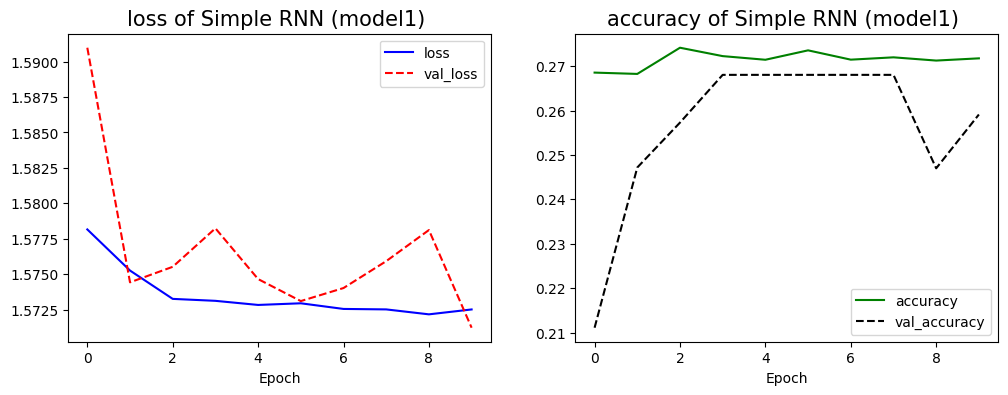

In [18]:
# Simple RNN 모델 (model1) 학습 결과 확인
plt.figure(figsize=(12, 4))
plt.title('Simple RNN (model1) ', fontsize= 15)

plt.subplot(1, 2, 1)
plt.title('loss of Simple RNN (model1) ', fontsize= 15)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'],'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('accuracy of Simple RNN (model1) ', fontsize= 15)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'],'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show

## 4.2 단방향 LSTM

In [14]:
#파라미터 설정
vocab_size = 2000 # 제일 많이 사용하는 사이즈
embedding_dim = 200  
max_length = 150    # 위에서 그래프 확인 후 정함
padding_type='post'

In [15]:
# LSTM 레이어를 사용한 모델 정의
class LSTM(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, max_length):
        super(LSTM, self).__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length)
        self.lstm1 = tf.keras.layers.LSTM(units=64, return_sequences=True)
        self.lstm2 = tf.keras.layers.LSTM(units=64, return_sequences=True)
        self.lstm3 = tf.keras.layers.LSTM(units=64)
        self.dense = tf.keras.layers.Dense(5, activation='softmax')

    def call(self, inputs):
        x = self.embedding(inputs)
        x = self.lstm1(x)
        x = self.lstm2(x)
        x = self.lstm3(x)
        return self.dense(x)
    
# LSTM 모델 인스턴스 생성
lstm = LSTM(vocab_size, embedding_dim, max_length)

# 모델 컴파일
lstm.compile(loss='categorical_crossentropy',  # 여러 개의 정답 중 하나를 맞추는 문제이므로 손실 함수는 categorical_crossentropy를 사용
              optimizer='adam',
              metrics=['accuracy'])

# 모델 구조 확인
lstm.build((None, max_length))
lstm.summary()

Model: "lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  400000    
                                                                 
 lstm_1 (LSTM)               multiple                  67840     
                                                                 
 lstm_2 (LSTM)               multiple                  33024     
                                                                 
 lstm_3 (LSTM)               multiple                  33024     
                                                                 
 dense (Dense)               multiple                  325       
                                                                 
Total params: 534,213
Trainable params: 534,213
Non-trainable params: 0
_________________________________________________________________


In [16]:
# 모델 실행해보기
history = lstm.fit(train_x, train_y, epochs=10, batch_size=100, validation_split= 0.2) 
  # 데이터가 50000개가 넘어 학습시간이 오래 걸리기 때문에 batch size 를 100으로 크게 잡았다
  # 추이를 확인하게 위해 일단 10회만 시도

Epoch 1/10
440/440 [==============================] - 77s 148ms/step - loss: 1.5717 - accuracy: 0.2756 - val_loss: 1.5738 - val_accuracy: 0.2680
Epoch 2/10
440/440 [==============================] - 21s 48ms/step - loss: 1.5708 - accuracy: 0.2761 - val_loss: 1.5719 - val_accuracy: 0.2680
Epoch 3/10
440/440 [==============================] - 16s 36ms/step - loss: 1.5704 - accuracy: 0.2761 - val_loss: 1.5727 - val_accuracy: 0.2680
Epoch 4/10
440/440 [==============================] - 14s 32ms/step - loss: 1.5704 - accuracy: 0.2761 - val_loss: 1.5711 - val_accuracy: 0.2680
Epoch 5/10
440/440 [==============================] - 14s 31ms/step - loss: 1.5703 - accuracy: 0.2761 - val_loss: 1.5711 - val_accuracy: 0.2680
Epoch 6/10
440/440 [==============================] - 13s 30ms/step - loss: 1.5705 - accuracy: 0.2761 - val_loss: 1.5715 - val_accuracy: 0.2680
Epoch 7/10
440/440 [==============================] - 10s 23ms/step - loss: 1.5704 - accuracy: 0.2761 - val_loss: 1.5711 - val_accuracy

<function matplotlib.pyplot.show(close=None, block=None)>

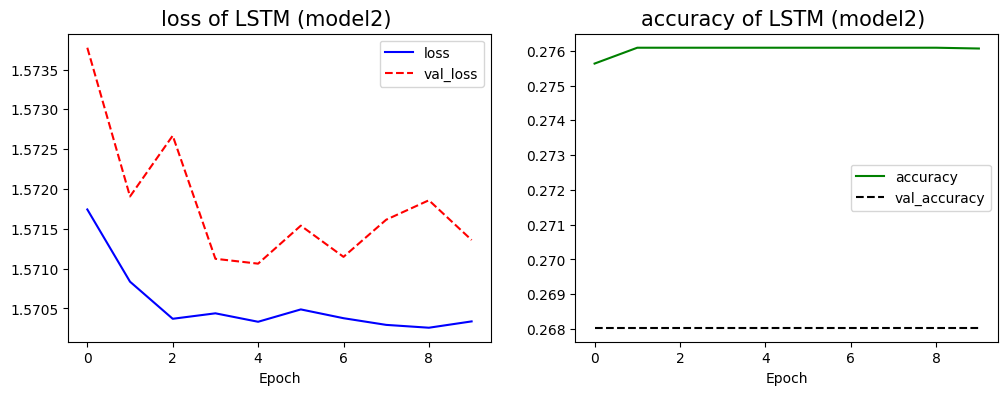

In [17]:
# 모델 학습 결과 확인
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title('loss of LSTM (model2) ', fontsize= 15)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'],'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('accuracy of LSTM (model2) ', fontsize= 15)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'],'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show

## 4.3 양방향 RNN

In [22]:
#파라미터 설정
vocab_size = 2000 # 제일 많이 사용하는 사이즈
embedding_dim = 200  
max_length = 150    # 위에서 그래프 확인 후 정함
padding_type='post'
#oov_tok = "<OOV>"

In [23]:
class BidirectionalRNN(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, max_length):
        super(BidirectionalRNN, self).__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length)
        self.rnn1 = tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units=64, return_sequences=True))
        self.rnn2 = tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units=64, return_sequences=True))
        self.rnn3 = tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units=64))
        self.dense = tf.keras.layers.Dense(5, activation='softmax')

    def call(self, inputs):
        x = self.embedding(inputs)
        x = self.rnn1(x)
        x = self.rnn2(x)
        x = self.rnn3(x)
        return self.dense(x) 

# Bidirectional RNN 모델 인스턴스 생성
bi_rnn = BidirectionalRNN(vocab_size, embedding_dim, max_length)

# 모델 컴파일
bi_rnn.compile(loss='categorical_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])

# 모델 구조 확인
bi_rnn.build((None, max_length))
bi_rnn.summary()

Model: "bidirectional_rnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     multiple                  400000    
                                                                 
 bidirectional (Bidirectiona  multiple                 33920     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  multiple                 24704     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  multiple                 24704     
 nal)                                                            
                                                                 
 dense_2 (Dense)             multiple                  645       
                                                 

In [24]:
# 모델 실행해보기
history = bi_rnn.fit(train_x, train_y, epochs=10, batch_size=100, validation_split= 0.2) 
  # 데이터가 50000개가 넘어 학습시간이 오래 걸리기 때문에 batch size 를 100으로 크게 잡았다
  # 추이를 확인하게 위해 일단 10회만 시도

Epoch 1/10
440/440 [==============================] - 254s 565ms/step - loss: 1.2243 - accuracy: 0.4951 - val_loss: 1.0458 - val_accuracy: 0.5912
Epoch 2/10
440/440 [==============================] - 240s 546ms/step - loss: 0.9215 - accuracy: 0.6457 - val_loss: 0.9316 - val_accuracy: 0.6428
Epoch 3/10
440/440 [==============================] - 247s 561ms/step - loss: 0.7776 - accuracy: 0.7057 - val_loss: 0.9784 - val_accuracy: 0.6286
Epoch 4/10
440/440 [==============================] - 243s 553ms/step - loss: 0.6539 - accuracy: 0.7553 - val_loss: 1.0507 - val_accuracy: 0.6181
Epoch 5/10
440/440 [==============================] - 248s 563ms/step - loss: 0.5876 - accuracy: 0.7799 - val_loss: 1.1447 - val_accuracy: 0.5903
Epoch 6/10
440/440 [==============================] - 248s 563ms/step - loss: 0.5203 - accuracy: 0.8046 - val_loss: 1.2777 - val_accuracy: 0.5971
Epoch 7/10
440/440 [==============================] - 256s 582ms/step - loss: 0.4214 - accuracy: 0.8442 - val_loss: 1.3600 -

<function matplotlib.pyplot.show(close=None, block=None)>

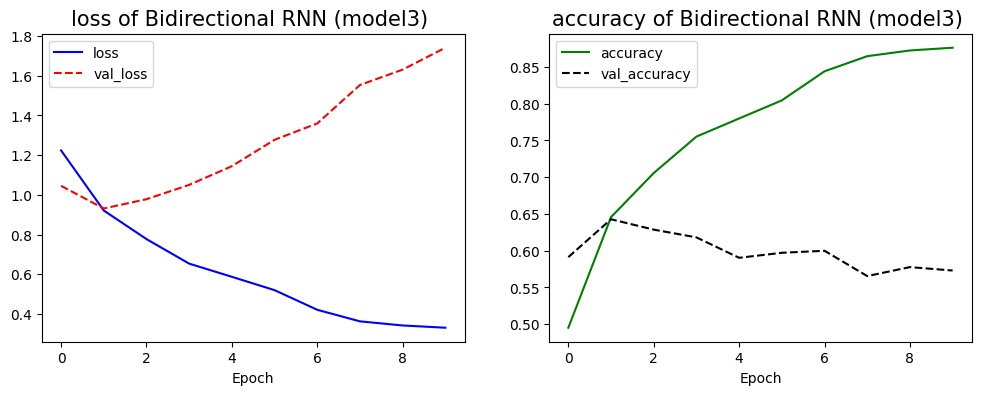

In [25]:
# 모델 학습 결과 확인
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title('loss of Bidirectional RNN (model3) ', fontsize= 15)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'],'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('accuracy of Bidirectional RNN (model3) ', fontsize= 15)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'],'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show

## 4.3 양방향 LSTM

In [18]:
#파라미터 설정
vocab_size = 2000 # 제일 많이 사용하는 사이즈
embedding_dim = 200  
max_length = 150    # 위에서 그래프 확인 후 정함
padding_type='post'
#oov_tok = "<OOV>"

In [19]:
# 양방향 LSTM 레이어를 사용한 모델 (model3) 정의
class BidirectionalLSTM(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, max_length):
        super(BidirectionalLSTM, self).__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length)
        self.lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64, return_sequences=True))
        self.lstm2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64, return_sequences=True))
        self.lstm3 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64))
        self.dense = tf.keras.layers.Dense(5, activation='softmax')

    def call(self, inputs):
        x = self.embedding(inputs)
        x = self.lstm1(x)
        x = self.lstm2(x)
        x = self.lstm3(x)
        return self.dense(x)
    
# Bidirectional LSTM 모델 인스턴스 생성
bi_lstm = BidirectionalLSTM(vocab_size, embedding_dim, max_length)

# 모델 컴파일
bi_lstm.compile(loss='categorical_crossentropy',  # 여러 개의 정답 중 하나를 맞추는 문제이므로 손실 함수는 categorical_crossentropy를 사용
                optimizer='adam',
                metrics=['accuracy'])

# 모델 구조 확인
bi_lstm.build((None, max_length))
bi_lstm.summary()

Model: "bidirectional_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     multiple                  400000    
                                                                 
 bidirectional (Bidirectiona  multiple                 135680    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  multiple                 98816     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  multiple                 98816     
 nal)                                                            
                                                                 
 dense_1 (Dense)             multiple                  645       
                                                

In [20]:
# 모델 실행해보기
history = bi_lstm.fit(train_x, train_y, epochs=50, batch_size=100, validation_split= 0.2) 
  # 양방향 LSTM 레이어에서는 batch size 를 100으로 잡고 50회 학습 해보았다.

Epoch 1/50
440/440 [==============================] - 65s 124ms/step - loss: 1.1317 - accuracy: 0.5392 - val_loss: 0.9358 - val_accuracy: 0.6371
Epoch 2/50
440/440 [==============================] - 28s 63ms/step - loss: 0.8697 - accuracy: 0.6652 - val_loss: 0.9046 - val_accuracy: 0.6562
Epoch 3/50
440/440 [==============================] - 27s 62ms/step - loss: 0.8049 - accuracy: 0.6886 - val_loss: 0.8902 - val_accuracy: 0.6593
Epoch 4/50
440/440 [==============================] - 22s 51ms/step - loss: 0.7610 - accuracy: 0.7064 - val_loss: 0.8793 - val_accuracy: 0.6699
Epoch 5/50
440/440 [==============================] - 22s 49ms/step - loss: 0.7246 - accuracy: 0.7193 - val_loss: 0.9103 - val_accuracy: 0.6656
Epoch 6/50
440/440 [==============================] - 21s 48ms/step - loss: 0.6977 - accuracy: 0.7312 - val_loss: 0.9355 - val_accuracy: 0.6584
Epoch 7/50
440/440 [==============================] - 21s 48ms/step - loss: 0.6732 - accuracy: 0.7409 - val_loss: 0.9548 - val_accuracy

<function matplotlib.pyplot.show(close=None, block=None)>

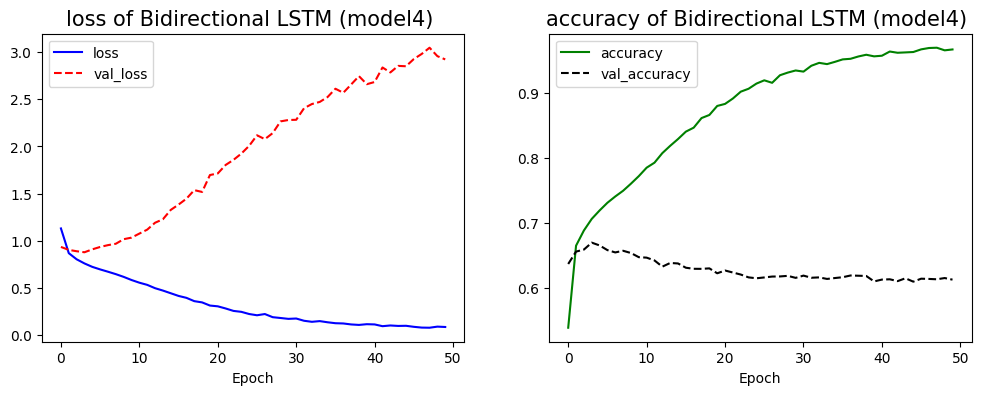

In [21]:
# 모델 학습 결과 확인
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title('loss of Bidirectional LSTM (model4) ', fontsize= 15)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'],'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('accuracy of Bidirectional LSTM (model4) ', fontsize= 15)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'],'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show

## 4.4 교차 검증 적용

- 계층 교차검증(StratifiedKFold) 적용하고 모델 일반화


In [22]:
# 계층 교차 검증
n_fold = 5  
seed = 42

cv = StratifiedKFold(n_splits = n_fold, shuffle=True, random_state=seed)

for i, (i_trn, i_val) in enumerate(cv.split(train_x, Y_train), 1):
    print(f'training model for CV #{i}')

    # 모델을 해당 fold의 학습 데이터로 학습
    bi_lstm.fit(train_x[i_trn], 
        to_categorical(Y_train[i_trn]),
        validation_data=(train_x[i_val], to_categorical(Y_train[i_val])),
        epochs=10,
        batch_size=512)

training model for CV #1
Epoch 1/10
86/86 [==============================] - 22s 257ms/step - loss: 0.5093 - accuracy: 0.8993 - val_loss: 0.4051 - val_accuracy: 0.9043
Epoch 2/10
86/86 [==============================] - 16s 186ms/step - loss: 0.3202 - accuracy: 0.9212 - val_loss: 0.3882 - val_accuracy: 0.9066
Epoch 3/10
86/86 [==============================] - 13s 156ms/step - loss: 0.2696 - accuracy: 0.9317 - val_loss: 0.3879 - val_accuracy: 0.9041
Epoch 4/10
86/86 [==============================] - 13s 147ms/step - loss: 0.2374 - accuracy: 0.9385 - val_loss: 0.3915 - val_accuracy: 0.9044
Epoch 5/10
86/86 [==============================] - 11s 133ms/step - loss: 0.2125 - accuracy: 0.9445 - val_loss: 0.3983 - val_accuracy: 0.9027
Epoch 6/10
86/86 [==============================] - 11s 133ms/step - loss: 0.1919 - accuracy: 0.9492 - val_loss: 0.4073 - val_accuracy: 0.9018
Epoch 7/10
86/86 [==============================] - 11s 126ms/step - loss: 0.1736 - accuracy: 0.9530 - val_loss: 0.41

기존 보다 개선된 결과 값을 보여준다. 하지만 val_loss 와 val_accuracy 결과값을 보면 조기종료 옵션을 추가해야할 것 같다.



## 5.1 양방향 LSTM 점수 측정

In [23]:
# 계층 교차 검증
n_fold = 5  
seed = 42

cv = StratifiedKFold(n_splits = n_fold, shuffle=True, random_state=seed)

# 테스트데이터의 예측값 담을 곳 생성
test_y = np.zeros((test_x.shape[0], 5))
history = []

# 조기 종료 옵션 추가
es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3,
                   verbose=1, mode='min', baseline=None, restore_best_weights=True)

for i, (i_trn, i_val) in enumerate(cv.split(train_x, Y_train), 1):
    print(f'training model for CV #{i}')

    temp = bi_lstm.fit(train_x[i_trn], 
            to_categorical(Y_train[i_trn]),
            validation_data=(train_x[i_val], to_categorical(Y_train[i_val])),
            epochs=10,
            batch_size=512,
            callbacks=[es])     # 조기 종료 옵션
    
    history.append(temp)
    test_y += bi_lstm.predict(test_x) / n_fold    # 나온 예측값들을 교차 검증 횟수로 나눈다



training model for CV #1
Epoch 1/10
86/86 [==============================] - 10s 119ms/step - loss: 0.0723 - accuracy: 0.9737 - val_loss: 0.0652 - val_accuracy: 0.9753
Epoch 2/10
86/86 [==============================] - 10s 113ms/step - loss: 0.0712 - accuracy: 0.9738 - val_loss: 0.0810 - val_accuracy: 0.9709
Epoch 3/10
86/86 [==============================] - 10s 114ms/step - loss: 0.0653 - accuracy: 0.9757 - val_loss: 0.0961 - val_accuracy: 0.9652
Epoch 4/10
86/86 [==============================] - 10s 117ms/step - loss: 0.0518 - accuracy: 0.9803 - val_loss: 0.0913 - val_accuracy: 0.9666
Epoch 4: early stopping
614/614 [==============================] - 10s 14ms/step
training model for CV #2
Epoch 1/10
86/86 [==============================] - 10s 114ms/step - loss: 0.0640 - accuracy: 0.9759 - val_loss: 0.0580 - val_accuracy: 0.9769
Epoch 2/10
86/86 [==============================] - 9s 109ms/step - loss: 0.0518 - accuracy: 0.9806 - val_loss: 0.0628 - val_accuracy: 0.9751
Epoch 3/10
8

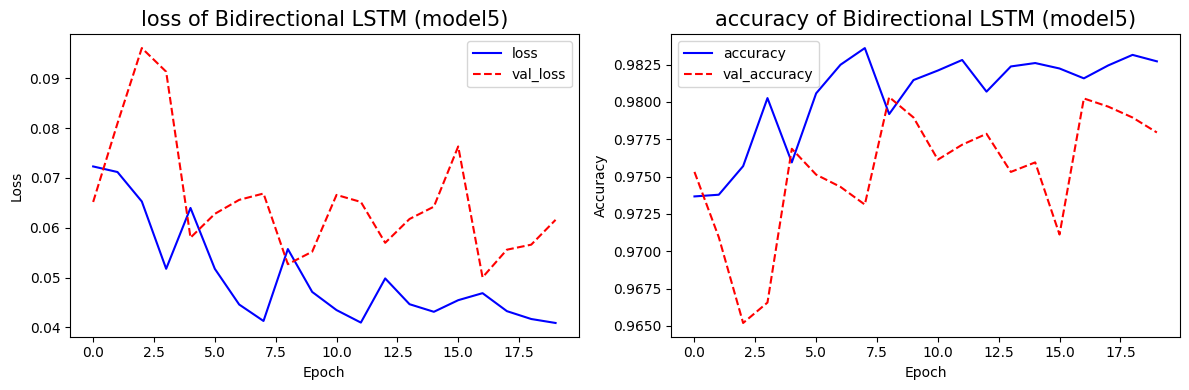

In [24]:
# history 데이터 결합
combined_history = {}

for i, hist in enumerate(history):
    for key, value in hist.history.items():
        if key in combined_history:
            combined_history[key].extend(value)
        else:
            combined_history[key] = value
            
# 모델 학습 결과 확인
plt.figure(figsize=(12, 4))
            
plt.subplot(1, 2, 1)
plt.title('loss of Bidirectional LSTM (model5)', fontsize=15)
plt.plot(combined_history['loss'], 'b-', label='loss')
plt.plot(combined_history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('accuracy of Bidirectional LSTM (model5)', fontsize=15)
plt.plot(combined_history['accuracy'], 'b-', label='accuracy')
plt.plot(combined_history['val_accuracy'], 'r--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
# sample_submission 에 대입
sample_submission = pd.read_csv("/content/drive/MyDrive/data_set/VC_DataSet/sample_submission.csv")
sample_submission[['0','1','2','3','4']] = test_y

# CSV 파일로 저장
sample_submission.to_csv('/content/drive/MyDrive/data_set/VC_DataSet/sample_submission_predictions.csv', index=False)
sample_submission

,index,0,1,2,3,4
0,0,0.000057,9.997716e-01,3.031159e-05,1.378911e-04,0.000003
1,1,0.004946,2.031842e-01,2.121573e-05,2.409571e-05,0.791824
2,2,0.588103,6.721686e-03,6.000693e-04,5.778908e-03,0.398796
3,3,0.000002,7.689756e-04,9.992111e-01,7.397879e-07,0.000017
4,4,0.999464,3.540005e-07,2.862190e-07,2.808808e-06,0.000533
...,...,...,...,...,...,...
19612,19612,0.000023,9.999044e-01,1.418410e-05,5.401601e-05,0.000004
19613,19613,0.000007,1.649661e-06,2.518579e-05,1.467960e-05,0.999951
19614,19614,0.000130,9.998059e-01,3.258781e-05,2.739223e-05,0.000004
19615,19615,0.065748,9.259693e-01,1.277845e-05,8.215825e-03,0.000054


## Score

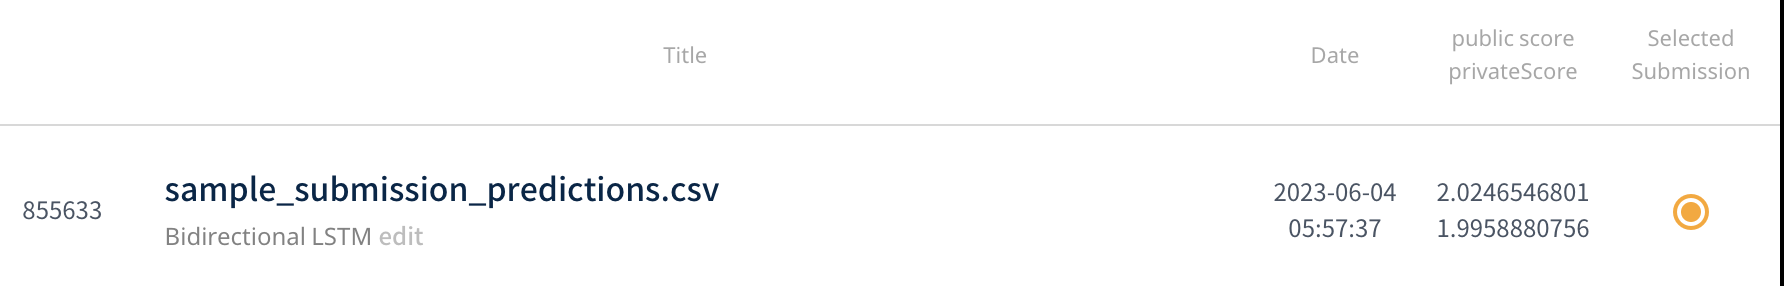

## 5.2 양방향 RNN 점수 측정

In [26]:
# 계층 교차 검증
n_fold = 5  
seed = 42

cv = StratifiedKFold(n_splits = n_fold, shuffle=True, random_state=seed)

# 테스트데이터의 예측값 담을 곳 생성
test_y = np.zeros((test_x.shape[0], 5))
history = []

# 조기 종료 옵션 추가
es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3,
                   verbose=1, mode='min', baseline=None, restore_best_weights=True)

for i, (i_trn, i_val) in enumerate(cv.split(train_x, Y_train), 1):
    print(f'training model for CV #{i}')

    temp = bi_rnn.fit(train_x[i_trn], 
            to_categorical(Y_train[i_trn]),
            validation_data=(train_x[i_val], to_categorical(Y_train[i_val])),
            epochs=10,
            batch_size=512,
            callbacks=[es])     # 조기 종료 옵션
    
    history.append(temp)
    test_y += bi_rnn.predict(test_x) / n_fold    # 나온 예측값들을 교차 검증 횟수로 나눈다



training model for CV #1
Epoch 1/10
86/86 [==============================] - 228s 3s/step - loss: 0.5648 - accuracy: 0.8206 - val_loss: 0.5010 - val_accuracy: 0.8450
Epoch 2/10
86/86 [==============================] - 228s 3s/step - loss: 0.4049 - accuracy: 0.8729 - val_loss: 0.4890 - val_accuracy: 0.8521
Epoch 3/10
86/86 [==============================] - 228s 3s/step - loss: 0.3385 - accuracy: 0.8947 - val_loss: 0.4975 - val_accuracy: 0.8494
Epoch 4/10
86/86 [==============================] - 230s 3s/step - loss: 0.2923 - accuracy: 0.9088 - val_loss: 0.5101 - val_accuracy: 0.8481
Epoch 5/10
86/86 [==============================] - 223s 3s/step - loss: 0.2574 - accuracy: 0.9205 - val_loss: 0.5293 - val_accuracy: 0.8446
Epoch 5: early stopping
614/614 [==============================] - 45s 72ms/step
training model for CV #2
Epoch 1/10
86/86 [==============================] - 236s 3s/step - loss: 0.3786 - accuracy: 0.8825 - val_loss: 0.3590 - val_accuracy: 0.8877
Epoch 2/10
86/86 [=====

[<keras.callbacks.History object at 0x7f82b6430d60>, <keras.callbacks.History object at 0x7f82b6d923e0>, <keras.callbacks.History object at 0x7f82b6dbb6a0>, <keras.callbacks.History object at 0x7f82b6c29360>, <keras.callbacks.History object at 0x7f82b6c40100>]


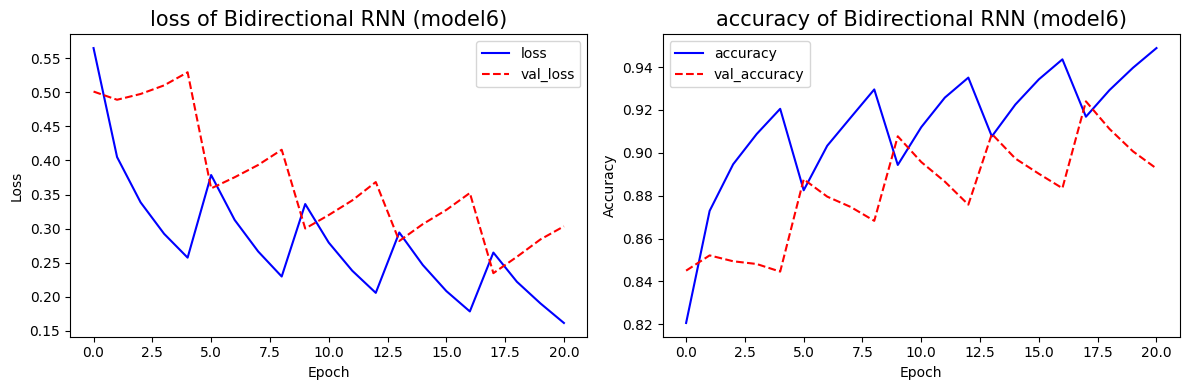

In [27]:
# 모델 학습 결과 확인
plt.figure(figsize=(12, 4))

combined_history = {}
print(history)
for i, hist in enumerate(history):
    for key, value in hist.history.items():
        if key in combined_history:
            combined_history[key].extend(value)
        else:
            combined_history[key] = value
            
plt.subplot(1, 2, 1)
plt.title('loss of Bidirectional RNN (model6)', fontsize=15)
plt.plot(combined_history['loss'], 'b-', label='loss')
plt.plot(combined_history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('accuracy of Bidirectional RNN (model6)', fontsize=15)
plt.plot(combined_history['accuracy'], 'b-', label='accuracy')
plt.plot(combined_history['val_accuracy'], 'r--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [28]:
# sample_submission 에 대입
sample_submission = pd.read_csv("/content/drive/MyDrive/data_set/VC_DataSet/sample_submission.csv")
sample_submission[['0','1','2','3','4']] = test_y

# CSV 파일로 저장
sample_submission.to_csv('/content/drive/MyDrive/data_set/VC_DataSet/rnn_predictions.csv', index=False)
sample_submission

,index,0,1,2,3,4
0,0,0.000620,0.998773,0.000316,0.000291,2.002509e-07
1,1,0.000933,0.998906,0.000031,0.000120,1.045709e-05
2,2,0.422168,0.005142,0.000374,0.000568,5.717481e-01
3,3,0.002310,0.001844,0.011649,0.000814,9.833835e-01
4,4,0.002118,0.002236,0.000413,0.248149,7.470834e-01
...,...,...,...,...,...,...
19612,19612,0.013748,0.986134,0.000015,0.000098,5.954300e-06
19613,19613,0.034685,0.000009,0.113454,0.006535,8.453170e-01
19614,19614,0.000011,0.999803,0.000033,0.000120,3.355517e-05
19615,19615,0.000313,0.999520,0.000006,0.000064,9.653360e-05


## Score

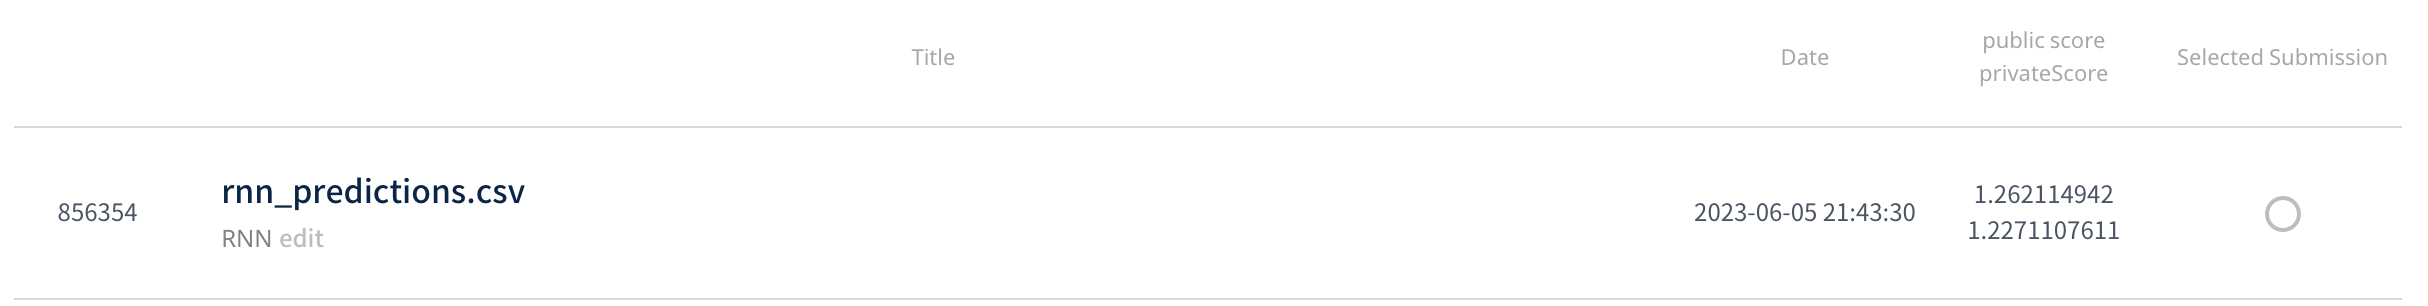